# Test X3 & X4: Prediction with Full Covariance Matrix GPU

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings

warnings.filterwarnings("ignore")

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 7})
mpl.rcParams.update({"grid.linewidth": 0.5})
mpl.rcParams.update({"legend.fontsize": 9})


def figsize(x, y, y_log_min=1, y_log_max=1):
    """
    Set figsize based on same bounding box to achive shared axes
    """
    x_const = 0.5421892781575521
    y_const = 0.8417361111111112
    return (
        x + x_const,
        (y + math.log10(y_log_max) - math.log10(y_log_min)) * 0.5 + y_const,
    )


# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [3]:
def mean_stddev(df, groupby_cols):
    new_df = df[df["i_loop"] != 0]
    new_df = (
        new_df.groupby(groupby_cols)["time"].agg(["mean", "std", "count"]).reset_index()
    )
    new_df.rename(columns={"std": "stddev", "count": "n_loops"}, inplace=True)
    return new_df

In [4]:
df_full = pd.read_csv("./data/X3/output-gpu.csv")
df_full = mean_stddev(
    df_full, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_streams"]
)

In [5]:
# load data

apex_dir_steps = "./data/X4/"

names_steps = [
    "predict_full_cov_step ressource allocation",
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "predict_full_cov_step copyback",
    "predict_full_cov_step ressource destroy",
    "assemble K_tiles",
    "assemble alpha_tiles",
    "assemble prior_K_tiles_full",
    "assemble cross_covariance_tiles",
    "assemble t_cross_covariance_tiles",
    "assemble zeros",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
    "forward trsv",
    "forward gemv",
    "backward trsv",
    "backward gemv",
    "forward_KcK trsm",
    "forward_KcK gemm",
    "predict gemv",
    "full_cov gemm",
    "pred_uncer diag_tile",
]

file_headers = [
    "n_cores",
    "n_train",
    "n_test",
    "n_tiles",
    "n_reg",
    "n_streams",
    "n_loops",
]


def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = (
                filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            )
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df["name"].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by="n_tiles")
    return df_combined


df_steps = apex_files_to_df(apex_dir_steps, names_steps)

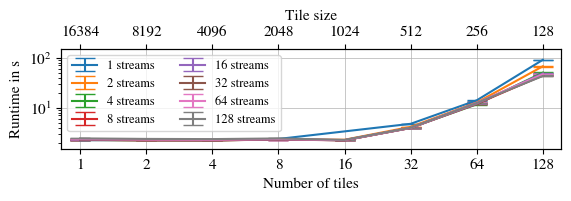

In [17]:
# plot for predict full cov

n_train = 16384

fig, ax = plt.subplots(figsize=figsize(5, 2))
ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")
ax.set_xlim(0.82, 155)
ax.set_ylim(1.5*10**0, 1.5*10**2)

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

for n_streams, group in df_full.groupby("n_streams"):
    group = group[(group["n_train"] == 16384) & (group["n_test"] == 16384)]
    err = utils.confidence_error(group, 0.95)
    plt.errorbar(group['n_tiles'], group['mean'], yerr=err, label=f"{n_streams} streams")

plt.legend(ncols=2)
plt.tight_layout(pad=0.1)
# plt.savefig("./pdf/predict-fullcov-gpu.pdf")

[ 0.00000000e+00 -1.76863349e+00 -2.73204975e+00  1.74410304e+00
 -1.71484966e+00  7.44254151e+01  4.12973500e+02  2.11155370e+03]
[   0.          -16.36943156  -24.68633202  -17.97876244   20.45707326
  452.56425565  660.572587   2410.28656008]
[   0.            2.84016938    4.06354904    7.3043523    -4.00991441
   28.92733639  152.78748171 1227.12010264]
[ 0.00000000e+00 -8.21415566e-01 -3.46629652e-01  9.92469363e+00
  4.08590893e+00  4.00768047e+01  4.64708401e+02  1.89342092e+03]
[   0.           -2.7223436    -3.00565052   -1.68454948  -11.60195728
   22.62082809  394.48974589 1564.94378957]


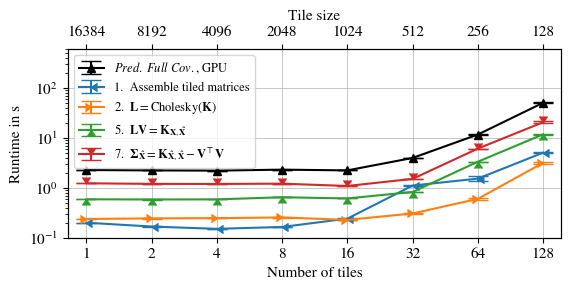

In [25]:
# plot for predict fullcov steps

n_train = 16384
n_streams = 4

fig, ax = plt.subplots(figsize=figsize(5, 3, 1, 6))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xlim(0.82, 155)
ax.set_ylim(10**-1, 6*10**2)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_4 = df_full[
    (df_full["n_streams"] == n_streams)
    & (df_full["n_train"] == 16384)
    & (df_full["n_test"] == 16384)
]
err = utils.confidence_error(df_full_4, 0.95)
ax.errorbar(
    df_full_4["n_tiles"],
    df_full_4["mean"],
    yerr=err,
    color="black",
    label=r"$\it{Pred.\ Full\ Cov.}$, GPU",
    marker="^"
)
first = df_full_4["mean"].values[0]
percents = (df_full_4["mean"].values - first) / first * 100
print(percents)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]
markers = [4,5,6,7]

for name, label, marker in zip(names, labels, markers):
    df_name = df_steps[
        (df_steps["name"] == name)
        & (df_steps["n_train"] == 16384)
        & (df_steps["n_test"] == 16384)
    ]
    df_name["mean"] = df_name["mean"].values
    err = utils.confidence_error(df_name, 0.95)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        # color=color,
        label=label,
        marker=marker
    )
    first = df_name["mean"].values[0]
    percents = (df_name["mean"].values - first) / first * 100
    print(percents)

ax.legend(loc="upper left")
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/predict-fullcov-gpu-steps.pdf")

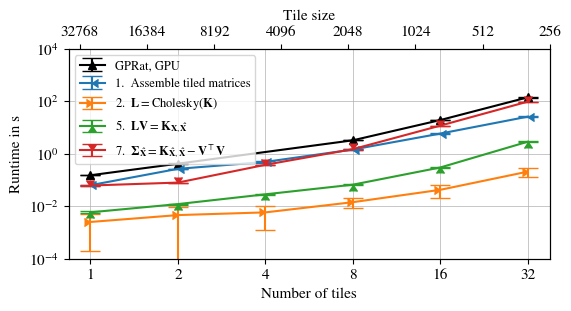

In [ ]:
# plot for predict fullcov steps

n_train = 16384
n_streams = 4

fig, ax = plt.subplots(figsize=figsize(5, 3))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
# ax.set_xlim(0.82, 155)
ax.set_ylim(10**-4, 10**4)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = df_full["n_tiles"].unique()
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_full_4 = df_full[(df_full["n_streams"] == n_streams) & (df_full["n_train"] == 1024)
        & (df_full["n_test"] == 16384)]
err = utils.confidence_error(df_full_4, 0.95)
ax.errorbar(
    df_full_4["n_tiles"],
    df_full_4["mean"],
    yerr=err,
    color="black",
    label=r"GPRat, GPU",
    marker="^",
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]
markers = [4, 5, 6, 7]

for name, label, marker in zip(names, labels, markers):
    df_name = df_steps[
        (df_steps["name"] == name)
        & (df_steps["n_train"] == 1024)
        & (df_steps["n_test"] == 16384)
    ]
    df_name["mean"] = df_name["mean"].values
    err = utils.confidence_error(df_name, 0.95)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        # color=color,
        label=label,
        marker=marker,
    )

ax.legend(loc="upper left")
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/predict-fullcov-gpu-steps-smaller.pdf")

[0.35259247 0.34274929 0.35016634 0.39751694 0.33612204 0.48925364
 1.15717092 4.87274647]
[0. 0. 0. 0. 0. 0. 0. 0.]
0.073382113
[  0.         -26.37663622 -35.80209117 -32.18767631 -38.79224083
  33.38803013 267.49685444 993.52529819]
0.23414204
[ 0.00000000e+00 -2.41095533e-01  1.47398861e+00  5.03551391e+00
 -5.14552790e+00  2.32261951e+01  1.46295264e+02  1.17298422e+03]
0.03786955
[   0.            2.03160323   28.08090405   90.91718808    3.43129506
   30.58673261  327.58373416 1681.28575333]
0.000232302
[    0.           219.9417138   1389.0000947   4462.11268091
  2159.57847974  2454.03440349  8676.04841973 28453.32756498]


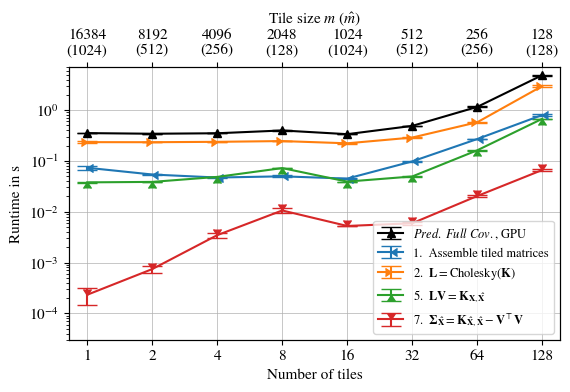

In [21]:
# plot for predict fullcov steps

n_train = 16384
n_streams = 4

fig, ax = plt.subplots(figsize=figsize(5, 6, 3, 2))

ax.set_xlabel("Number of tiles")
ax.set_ylabel("Runtime in s")
ax.set_xlim(0.82, 155)
ax.set_ylim(3*10**-5, 7*10**0)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks

ax_top = ax.twiny()

xticks = np.array([1, 2, 4, 8, 16, 32, 64, 128])
tile_sizes = n_train / xticks

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel(r"Tile size $m$ ($\hat m$)")
ax_top.set_xticks(xticks, ["16384\n(1024)", "8192\n(512)", "4096\n(256)", "2048\n(128)", "1024\n(1024)", "512\n(512)", "256\n(256)", "128\n(128)"])

df_full_4 = df_full[
    (df_full["n_streams"] == n_streams)
    & (df_full["n_train"] == 16384)
    & (df_full["n_test"] == 1024)
]
err = utils.confidence_error(df_full_4, 0.95)
ax.errorbar(
    df_full_4["n_tiles"],
    df_full_4["mean"],
    yerr=err,
    color="black",
    label=r"$\it{Pred.\ Full\ Cov.}$, GPU",
    marker="^",
)
first = df_full_4["mean"].values
print(first)
percents = (df_full_4["mean"].values - first) / first * 100
print(percents)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]
markers = [4, 5, 6, 7]

for name, label, marker in zip(names, labels, markers):
    df_name = df_steps[
        (df_steps["name"] == name)
        & (df_steps["n_train"] == 16384)
        & (df_steps["n_test"] == 1024)
    ]
    df_name["mean"] = df_name["mean"].values
    err = utils.confidence_error(df_name, 0.95)
    ax.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9,
        yerr=err / 10**9,
        # color=color,
        label=label,
        marker=marker,
    )
    first = df_name["mean"].values[0]
    print(first/10**9)
    percents = (df_name["mean"].values - first) / first * 100
    print(percents)

ax.legend()
fig.tight_layout(pad=0.1)
fig.savefig("./pdf/predict-fullcov-gpu-steps-larger.pdf")